In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def autocorrelation(x, max_lag=1000):
    n = len(x)                                       
    x_mean = np.mean(x)                              
    x_var = np.var(x)                                

    if x_var == 0:                                   
        return np.zeros(max_lag)                     

    acf = np.zeros(max_lag)                          
    for t in range(max_lag):                         
        sum_product = np.mean(x[:n - t] * x[t:])     
        acf[t] = (sum_product - x_mean**2) / x_var    
    return acf                                       

In [4]:
def block_analysis(data, max_block_size=5000):
    raw_bs = np.logspace(1, np.log10(max_block_size), 50)  
    block_sizes = np.unique(raw_bs.astype(int))            
    uncertainties = []                                      
    used_bs = []                                           

    for bs in block_sizes:                                  
        if bs > len(data) // 2:                             
            continue
        n_blocks = len(data) // bs                          
        
        blocks = data[:bs * n_blocks].reshape(n_blocks, bs).mean(axis=1)
       
        uncertainties.append(blocks.std(ddof=1) / np.sqrt(n_blocks))
        used_bs.append(bs)                                  

    return np.array(used_bs), np.array(uncertainties)      

In [5]:
def load_scalar(filename, col=1, skip_lines=1):
    try:
        return np.loadtxt(
            filename,
            dtype=float,
            skiprows=skip_lines,
            usecols=[col]
        )
    except Exception as e:
        print(f"Errore nel caricamento di {filename}: {e}")
        return None

In [6]:
def leggi_dati_gofr(nome_file):
    x, y, yerr = [], [], []
    with open(nome_file, 'r') as f:
        for riga in f:
            if riga.strip(): 
                valori = riga.strip().split()
                if len(valori) >= 3:
                    x.append(float(valori[0]))
                    y.append(float(valori[1]))
                    yerr.append(float(valori[2]))
    return np.array(x), np.array(y), np.array(yerr)

In [7]:
def leggi_dati(nome_file):
    x, y, yerr = [], [], []
    with open(nome_file, 'r') as f:
        for riga in f:
            if riga.strip():
                valori = riga.strip().split()
                if len(valori) >= 4:
                    x.append(float(valori[0]))
                    y.append(float(valori[2]))
                    # valori[2] viene ignorato
                    yerr.append(float(valori[3]))
    return np.array(x), np.array(y), np.array(yerr)

---

# Esercizio 7.2

Prima di procedere all'esecuzione dell'esercizio ho aggiunto al codice le correzioni di coda ad $U$ e $P$. Le correzioni di coda (tail corrections) servono a tenere conto dei contributi al potenziale che vengono trascurati oltre il raggio di cutoff $r_c$.

L'esercizio richiede di eseguire una simulazione Monte-Carlo $(N,V,T)$ e di dinamica molecolare $(N,V,E)$ di un gas con potenziale di Lennard-Jones. L'obiettivo è calcolare la funzione di autocorrelazione di $U/N$ e stimare l'incertezza statistica calcolata con il data-blocking su $U/N$, in funzione della lunghezza $L$ dei blocchi. Le condizioni iniziali per la simulazione MC sono $\rho^* = 0.8$, $T^* = 1.443$, $r_c^* = 2.5$ per MD, mentre per MC il parametro di temperatura è sostituito dalla lunghezza dello step $dt^* = 0,103$.


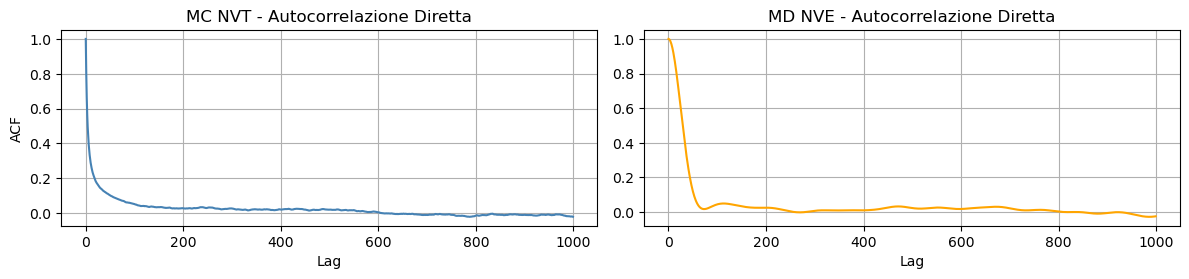

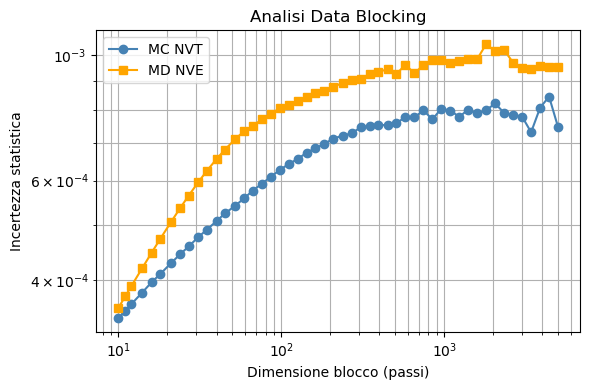

In [9]:
# -------------------------
#  1) Caricamento dati MC e MD
# -------------------------
U_mc = load_scalar('OUTPUT/potential_energy_NVT_ex_7_2.dat', col=1)    
U_md = load_scalar('OUTPUT/potential_energy_NVE_ex_7_2.dat', col=1)    

# -------------------------
#  2) Calcolo dell'autocorrelazione
# -------------------------
max_lag = 1000                           

# 2a) Metodo diretto MC                
acf_mc = autocorrelation(U_mc, max_lag=max_lag)

# 2b) Metodo diretto MD
acf_md = autocorrelation(U_md, max_lag=max_lag)

# -------------------------
#  3) Plot dei risultati di autocorrelazione
# -------------------------
plt.figure(figsize=(12, 5))            #

# 3a) Autocorrelazione diretta MC
plt.subplot(2, 2, 1)                  
plt.plot(acf_mc, color = "steelblue")                
plt.title('MC NVT - Autocorrelazione Diretta')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid()

# 3b) Autocorrelazione diretta MD
plt.subplot(2, 2, 2)                  
plt.plot(acf_md, color = "orange")
plt.title('MD NVE - Autocorrelazione Diretta')
plt.xlabel('Lag')
plt.grid()

plt.tight_layout()                     
plt.show()                            

bs_mc, err_mc = block_analysis(U_mc)    
bs_md, err_md = block_analysis(U_md)   

plt.figure(figsize=(6, 4))             
plt.loglog(bs_mc, err_mc, 'o-', label='MC NVT', color = "steelblue")  
plt.loglog(bs_md, err_md, 's-', label='MD NVE', color = "orange") 
plt.xlabel('Dimensione blocco (passi)')
plt.ylabel('Incertezza statistica')
plt.title('Analisi Data Blocking')
plt.legend()
plt.grid(True, which='both')           
plt.tight_layout()
plt.show()                             


### Autocorrelazione
La funzione di autocorrelazione $\chi (t)$ di molti processi stocastici con memoria finita ha tipicamente la forma di un esponenziale decrescente:

$$\chi (t) \approx e^{(-t/t_c)}$$

con $t_c$ tempo di correlazione che rappresenta la scala temporale su cui la funzione di autocorrelazione decade significativamente. Dal confronto tra i due grafici è evidente una maggiore correlazione tra i dati della simulazione MD rispetto alla simulazione MC. Per MC infatti $\chi (t)$ Ha un brusco calo nell'autocorrelazione fino $t \approx 200$ e valore prossimo al nullo verso $t \approx 600$. Per MD si ha invece un tempo di correlazione più corto che porta una decrescita iniziale più brusca fino a $t \approx 100$, ma che si protrae con oscillazioni fino a $t \approx 800$.

Il tempo di correlazione della simulazione Monte Carlo (MC) è generalmente minore rispetto a quello nella simulazione Molecular Dynamics (MD) perché in MC ogni nuova configurazione viene generata tramite una mossa casuale che viene accettata o rifiutata secondo il criterio di Metropolis.

Di conseguenza:
- Non esiste un’evoluzione temporale continua e deterministica, come invece avviene in MD.
- Le configurazioni possono cambiare in modo brusco da un passo all’altro, senza seguire una traiettoria temporale fluida.
- Questo favorisce una decorrelazione più rapida tra configurazioni successive, con un tempo di correlazione generalmente più breve. In MD, invece, la dinamica segue le leggi di moto classiche, quindi i cambiamenti sono continui e correlati nel tempo, portando a tempi di correlazione più lunghi.

### Errore statistico in funzione della lunghezza di blocco

All'inizio, con valori piccoli di $L$, l'errore è sottostimato perché il numero di blocchi è molto grande.

Questo comporta due effetti principali:
- I blocchi sono troppo corti per rompere efficacemente le correlazioni temporali tra i dati, quindi le medie di blocco non sono indipendenti. L'ipotesi su cui si basa il data blocking è proprio quella di suddividere il campione in sottocampioni psuedoindipendeti, in modo da poter fare la statistica su un set di medie di campione. Se i campioni ha un raggio di correlazione è come se le medie indipendenti fossero meno di quelle effettivamente calcolate:
$$\sigma ^2_{\bar{x}} = \frac{\sigma ^ 2}{N_{eff}}$$
$$N_{eff} < N$$
- All'aumentare di $L$, l'errore stimato si stabilizza attorno a un certo valore.

Se si continua ad aumentare $L$ fino a valori comparabili con il numero di passi MC il numero di blocchi diventa molto piccolo.

In questa situazione:
- Le fluttuazioni dell'errore stimato diventano più marcate e "violente".
- L'errore risulta sovrastimato perché si basa su poche medie di blocco molto variabili.
- L'incertezza sull'errore stesso cresce in modo significativo, rendendo la stima meno affidabile.

Si osserva che l'errore MC risulta minore dell'errore MD, tale differenza è dovuta alla maggiore correlazione dei dati nei blocchi di MD. L'incertezza sulla media è pari a

$$\sigma_{X} = \frac{\sigma}{\sqrt{N}}$$

con $N$ numero di dati indipendenti.
Osservando il plateau il numero effettivo di dati indipendenti è 

$$N_{eff} \approx \frac{N}{2t_c}$$

di conseguenza l'errore stimato risulta maggiore in una simulazione MD.

# Esercizio 7.4

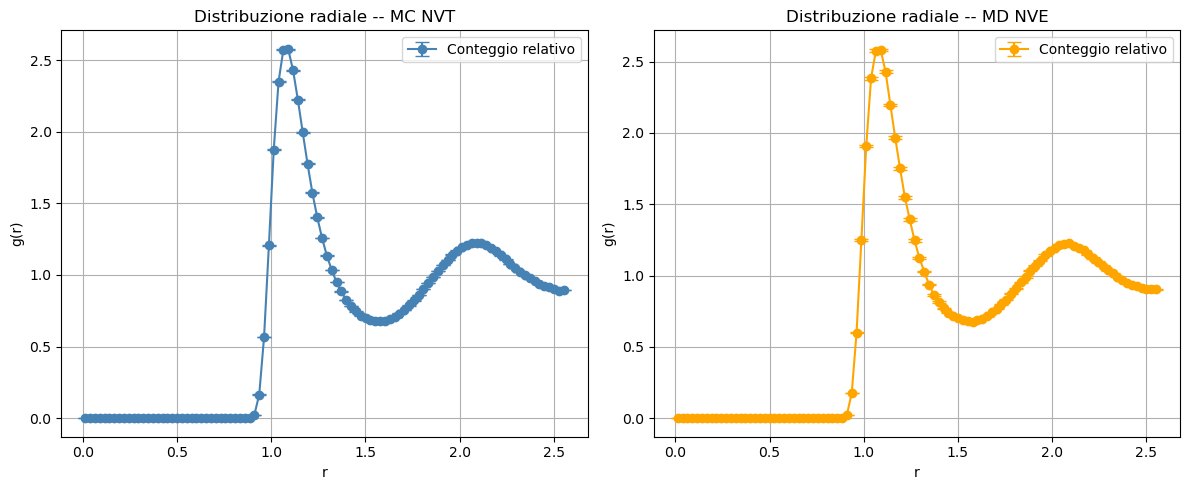

In [10]:
# Leggi e ordina i dati
x, y, yerr = leggi_dati_gofr("OUTPUT/gofr_data/gofr_NVT.dat")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --- Grafico 1: Dati con barre di errore (punti)
ax1.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, color='steelblue', label='Conteggio relativo')
ax1.set_title('Distribuzione radiale -- MC NVT')
ax1.set_xlabel('r')
ax1.set_ylabel('g(r)')
ax1.grid(True)
ax1.legend()

# --- Grafico 2: Istogramma con puntini sopra
x, y, yerr = leggi_dati_gofr("OUTPUT/gofr_data/gofr_NVE.dat")

ax2.errorbar(x, y, yerr=yerr, fmt='o-', color='orange', capsize=5, label='Conteggio relativo')
ax2.set_title('Distribuzione radiale -- MD NVE')
ax2.set_xlabel('r')
ax2.set_ylabel('g(r)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

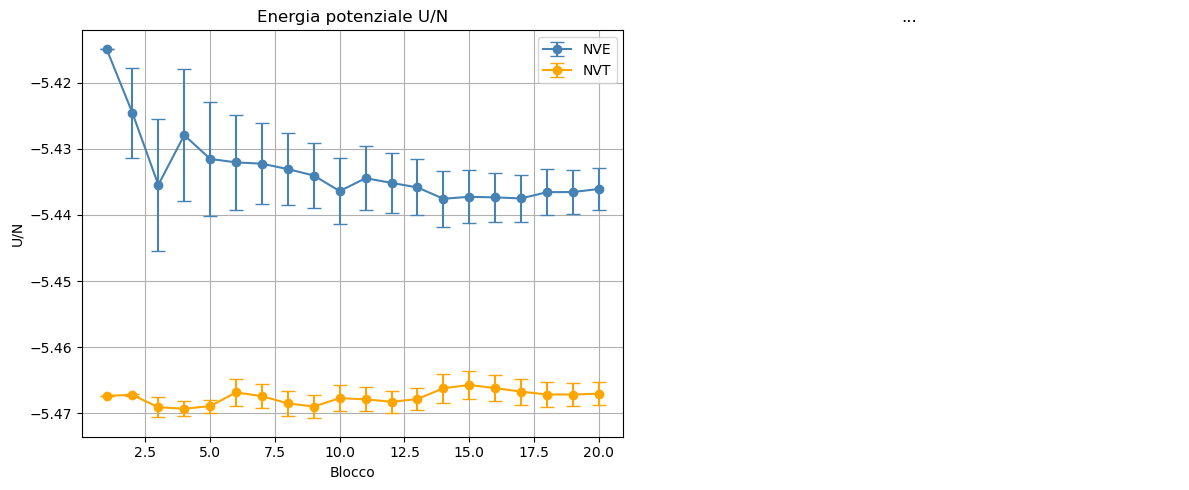

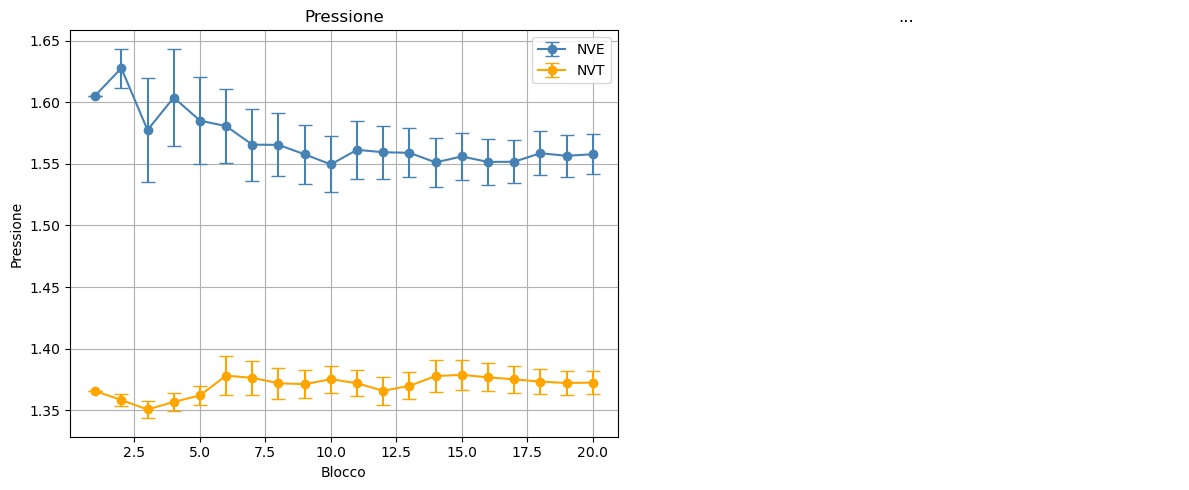

In [10]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# NVE
x, y, yerr = leggi_dati('OUTPUT/potential_energy_NVE_ex_7_4.dat')
ax1.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, color='steelblue', label='NVE')
# NVT
x, y, yerr = leggi_dati('OUTPUT/potential_energy_NVT_ex_7_4.dat')
ax1.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, color='orange', label='NVT')

ax1.set_title('Energia potenziale U/N')
ax1.set_xlabel('Blocco')
ax1.set_ylabel('U/N')
ax1.grid(True)
ax1.legend()


ax2.set_title('...')  
ax2.axis('off')   

plt.tight_layout()
plt.show()

# --- FIGURA 2: Pressione ---
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5))

# NVE
x, y, yerr = leggi_dati('OUTPUT/pressure_NVE_ex_7_4.dat')
ax3.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, color='steelblue', label='NVE')
# NVT
x, y, yerr = leggi_dati('OUTPUT/pressure_NVT_ex_7_4.dat')
ax3.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5, color='orange', label='NVT')

ax3.set_title('Pressione')
ax3.set_xlabel('Blocco')
ax3.set_ylabel('Pressione')
ax3.grid(True)
ax3.legend()

ax4.set_title('...')
ax4.axis('off')

plt.tight_layout()
plt.show()

Dai grafici emerge che i valori di pressione e energia interna per particella differiscono nelle due simulazioni. La distribuzione radiale invece combacia perfettamente. Evidentemente $P$ e $U/N$ sono più sensibili al metodo di campionamento e la discrepanza è attribuibile al diverso modo in cui i due metodi esplorano lo spazio delle configurazioni e alle fluttuazioni statistiche.

Nel grafico della distribuzione radiale si osserva un massimo assoluto per $r \approx 1.2$ che indica la distanza più probabile di interazione tra le particelle, cioè il raggio di “primo vicino”; un secondo massimo si ha per $r \approx 2.1$ e indica la presenza di un ordinamento a corto raggio più ampio. Questo significa che, oltre ai primi vicini immediati (primo picco), le particelle tendono a disporsi anche in “gusci” successivi intorno a una particella centrale, creando una struttura organizzata fino a una certa distanza. Per distanze grandi, cioè per $r \to \infty$ $g(r) \to 1$